# Bayesian Poisson回帰

* 黒木玄
* 2020-09-16

Bayesian Poisson回帰と最尤法(+ Wald検定で使う正規分布近似)によるPoisson回帰の結果が近似的に一致することを数値的に確認する.

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#データ生成" data-toc-modified-id="データ生成-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>データ生成</a></span></li><li><span><a href="#平坦事前分布の場合" data-toc-modified-id="平坦事前分布の場合-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>平坦事前分布の場合</a></span></li><li><span><a href="#正規事前分布の場合" data-toc-modified-id="正規事前分布の場合-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>正規事前分布の場合</a></span></li></ul></div>

In [1]:
ENV["COLUMNS"] = 120
using Distributions
using ForwardDiff
using LinearAlgebra
using Optim
using Random
using StatsPlots
default(fmt=:png, titlefontsize=10, plot_titlefontsize=10)
using Turing

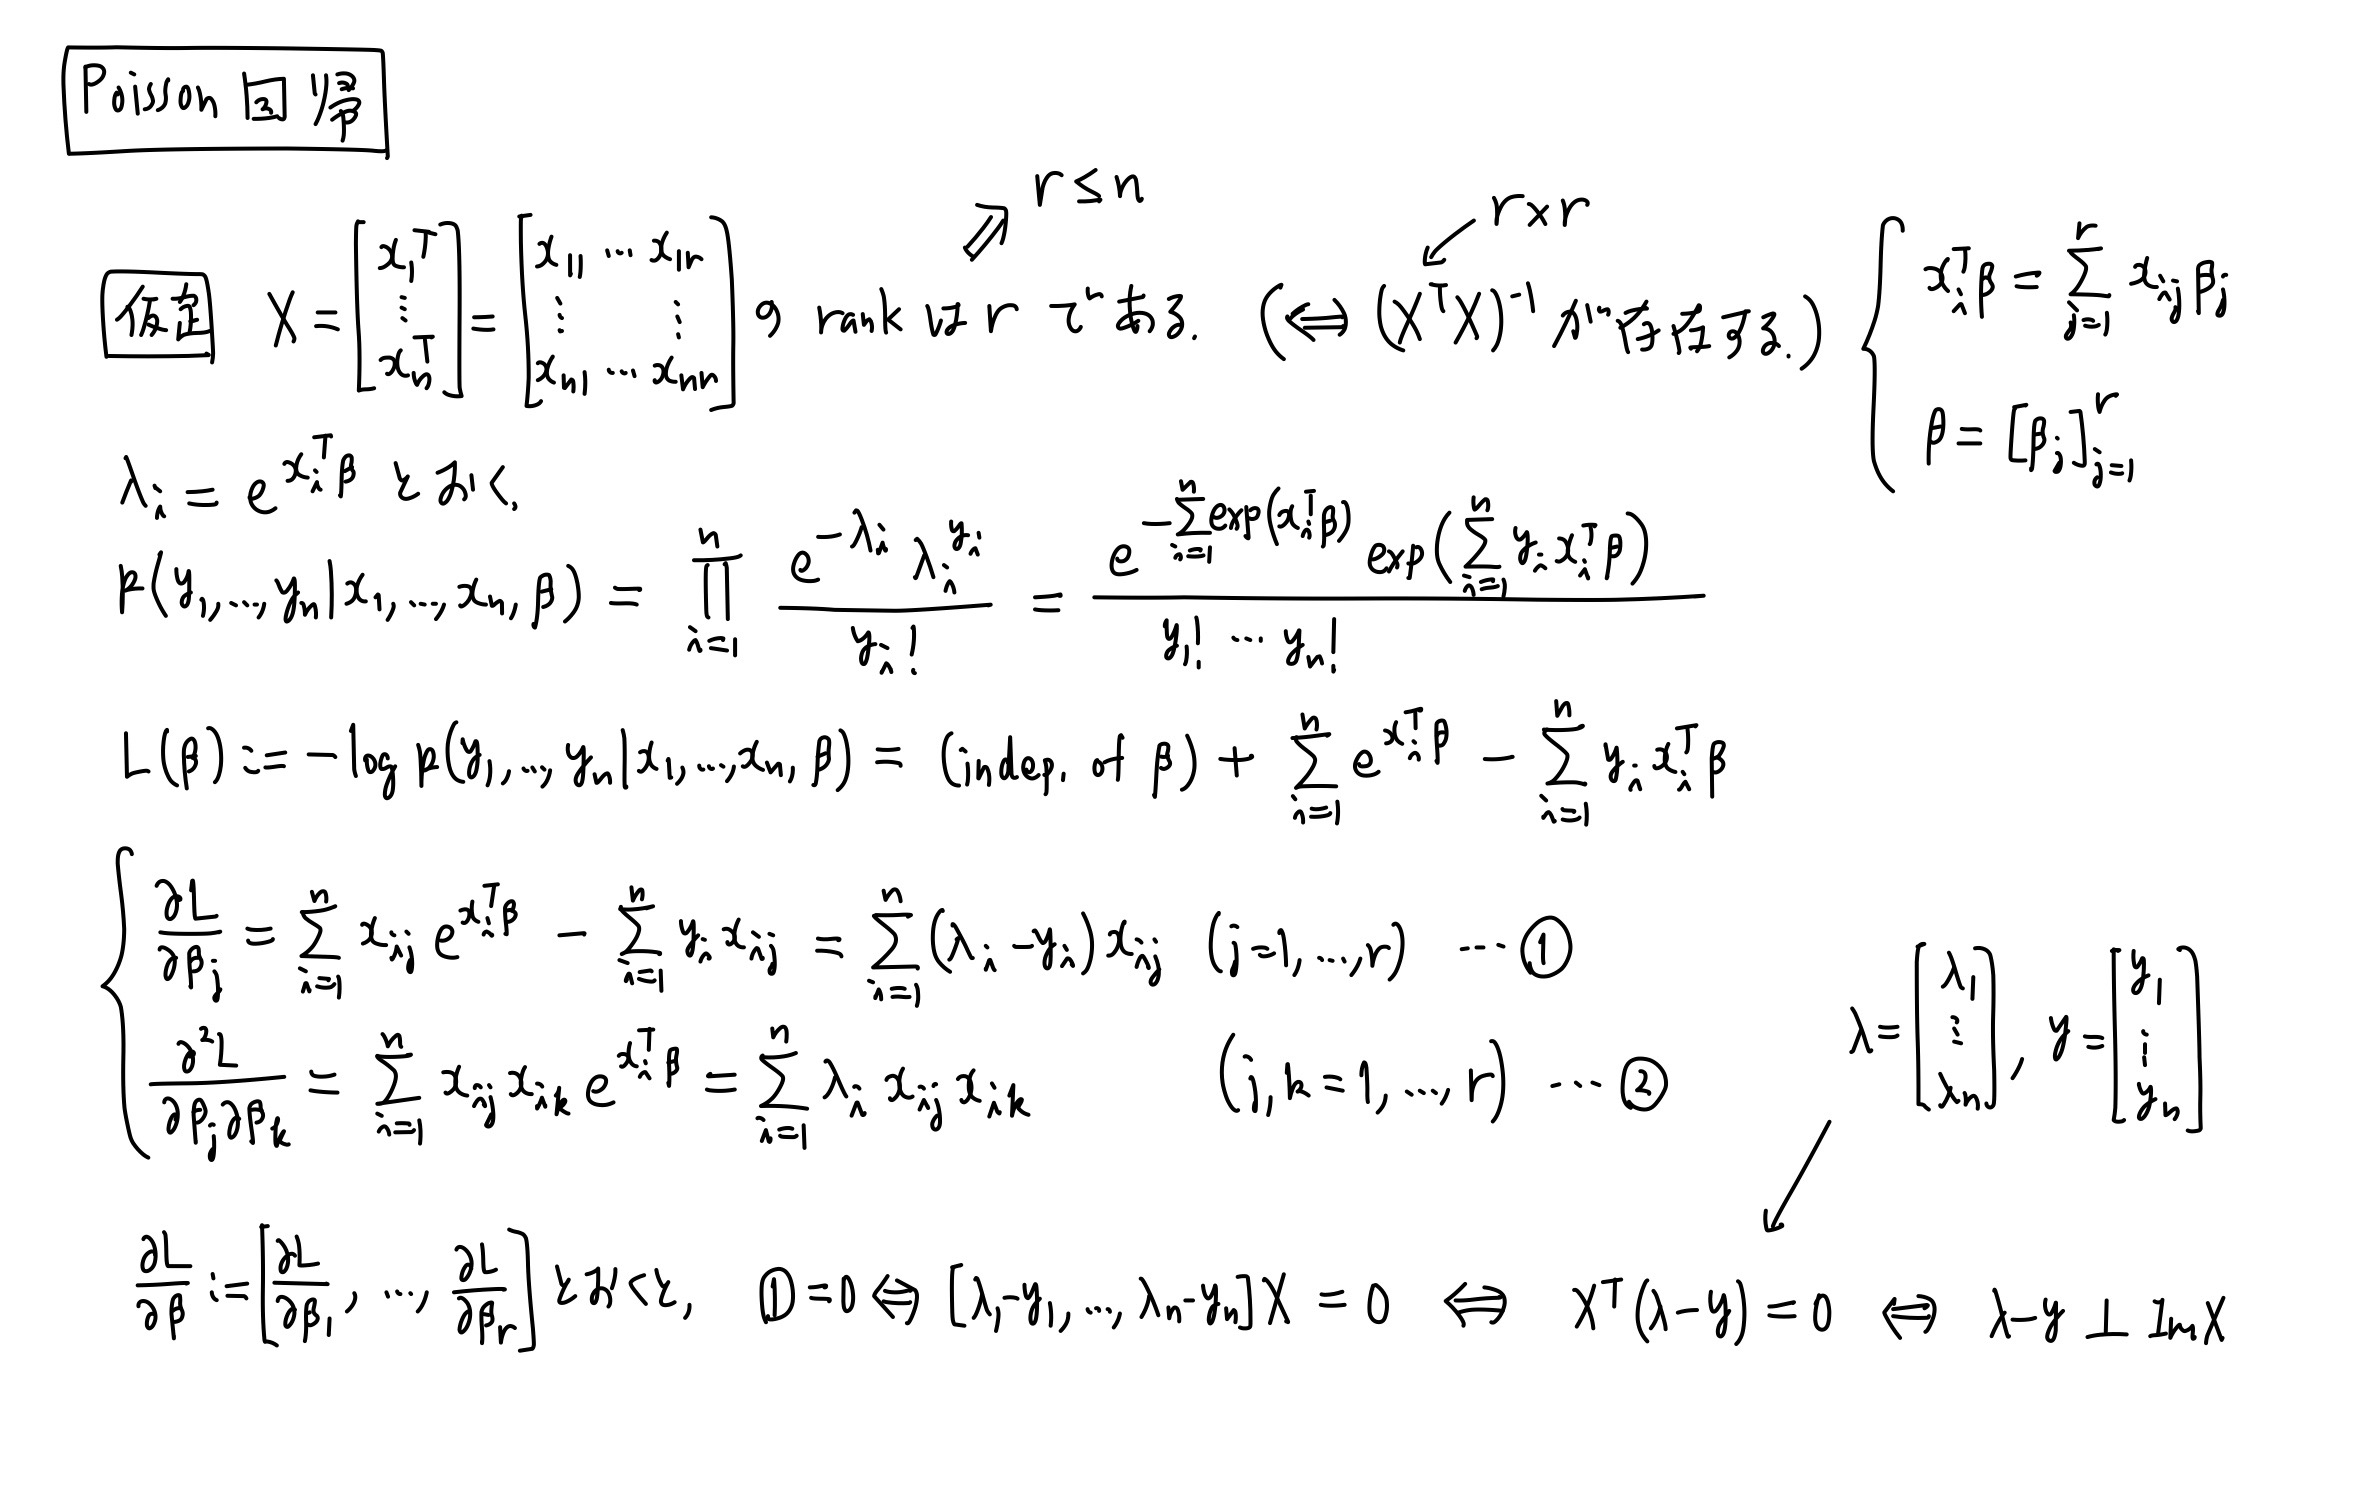

In [2]:
# Poisson回帰の対数尤度函数の-1倍とその1階と2階の導函数達
# 1階の導函数はスコア統計量と呼ばれ, 2階の導函数の期待値はFisher情報量と呼ばれる.
# この場合に2階の導函数は確率変数の y を含まないので,
# 2階の導函数がそのままFisher情報量になる.

function negloglik_poissonreg(x, y, β)
    -sum(logpdf(Poisson(exp(β[1] + β[2]*x)), y) for (x, y) in zip(x, y))
end

function scorestat_poissonreg(x, y, β)
    ForwardDiff.gradient(β -> negloglik_poissonreg(x, y, β), β)
end

function scorestat_poissonreg_explicit(x, y, β)
    λ(i) = exp(β[1] + β[2]*x[i])
    A = sum(λ(i) - y[i] for i in eachindex(x, y))
    B = sum((λ(i) - y[i])*x[i] for i in eachindex(x, y))
    [A, B]
end

function fisherinfo_poissonreg(x, y, β)
    ForwardDiff.hessian(β -> negloglik_poissonreg(x, y, β), β)
end

function fisherinfo_poissonreg_explicit(x, y, β)
    λ(i) = exp(β[1] + β[2]*x[i])
    a = sum(λ(i) for i in eachindex(x))
    b = sum(λ(i)*x[i] for i in eachindex(x))
    c = sum(λ(i)*x[i]^2 for i in eachindex(x))
    Symmetric([a b; b c])
end

fisherinfo_poissonreg_explicit (generic function with 1 method)

In [3]:
# 最尤推定 + Wald法で使う正規分布近似における
# 定数パラメータβと確率変数β̂の役割を交換したもの.
# 以下ではβ̂の側は定数とみなされており, βの側が確率変数とみなされている.
# これは本質的にBayes統計での事後分布の対数の2次近似になっている.

function mvnormal_approx_posterior_poissonreg(x, y)
    o = optimize(β->negloglik_poissonreg(x, y, β), zeros(2), LBFGS())
    β̂ = o.minimizer # maximum likelihood estimate
    Î = fisherinfo_poissonreg_explicit(x, y, β̂) # Fisher information matrix
    MvNormal(β̂, inv(Î)) # mvnormal approximation of the posterior of β
end

mvnormal_approx_posterior_poissonreg (generic function with 1 method)

In [4]:
# data
Random.seed!(4649373)
n = 20
x = sort(rand(Uniform(0, 3), n))
y = @. rand(Poisson(exp(-0.2 + 1.0x)))

# maximum likelihood estimate
o = optimize(β->negloglik_poissonreg(x, y, β), zeros(2), LBFGS())
β̂ = o.minimizer

2-element Vector{Float64}:
 -0.5413254790226775
  1.112527243066463

In [5]:
scorestat_poissonreg(x, y, β̂)

2-element Vector{Float64}:
 -1.3640111262702703e-10
 -8.085891067821649e-9

In [6]:
scorestat_poissonreg_explicit(x, y, β̂)

2-element Vector{Float64}:
 -1.3639933627018763e-10
 -8.085880409680613e-9

In [7]:
fisherinfo_poissonreg(x, y, β̂)

2×2 Matrix{Float64}:
  80.0    168.908
 168.908  404.544

In [8]:
Î = fisherinfo_poissonreg_explicit(x, y, β̂)

2×2 Symmetric{Float64, Matrix{Float64}}:
  80.0    168.908
 168.908  404.544

In [9]:
@show β̂ inv(Î);

β̂ = [-0.5413254790226775, 1.112527243066463]
inv(Î) = [0.10552745282553296 -0.044060624913659044; -0.044060624913659044 0.020868449138594106]


In [10]:
mvnormal_approx_posterior_poissonreg(x, y)

FullNormal(
dim: 2
μ: [-0.5413254790226775, 1.112527243066463]
Σ: [0.10552745282553296 -0.044060624913659044; -0.044060624913659044 0.020868449138594106]
)


## データ生成

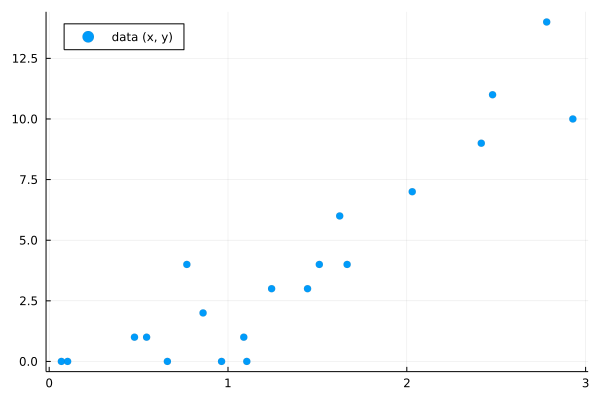

In [11]:
Random.seed!(4649373)
n = 20
β₀, β₁ = -0.2, 1.0
x = sort(rand(Uniform(0, 3), n))
y = @. rand(Poisson(exp(β₀ + β₁*x)))
scatter(x, y; label="data (x, y)", msw=0, legend=:topleft)

## 平坦事前分布の場合

In [12]:
@model function poissonreg(x, y)
    β₀ ~ Turing.Flat()
    β₁ ~ Turing.Flat()
    for i in eachindex(x, y)
        y[i] ~ Poisson(exp(β₀ + β₁*x[i]))
    end
end

poissonreg (generic function with 2 methods)

In [13]:
chn = sample(poissonreg(x, y), NUTS(), MCMCThreads(), 10^5, 3);

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191


In [14]:
chn

Chains MCMC chain (100000×14×3 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 3
Samples per chain = 100000
Wall duration     = 16.46 seconds
Compute duration  = 47.96 seconds
parameters        = β₀, β₁
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ess_per_sec 
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64       Float64 

          β₀   -0.5650    0.3253     0.0006    0.0014   55834.5046    1.0000     1164.0919
          β₁    1.1177    0.1445     0.0003    0.0006   56037.4242    1.0001     1168.3226

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          β₀   -1.2271   -0.7812   -0.5

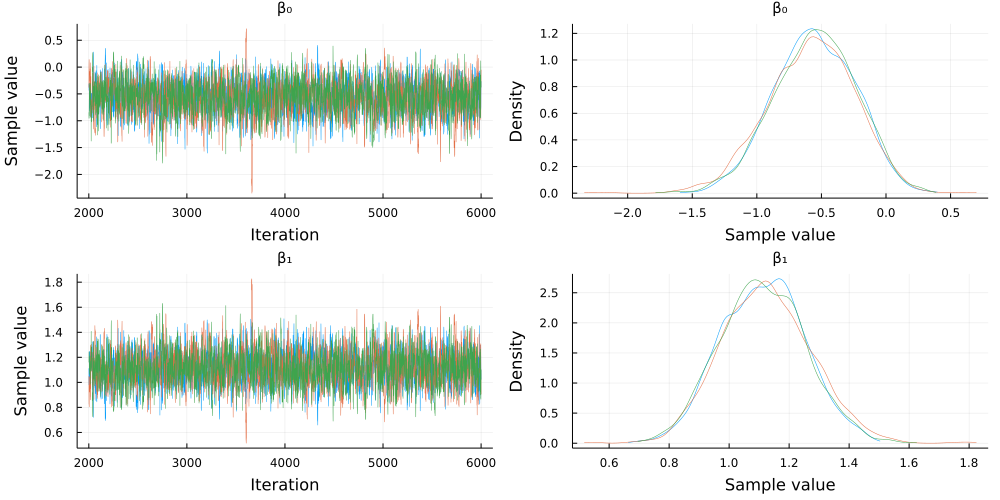

In [15]:
plot(chn[1001:5000]; lw=0.5, leftmargin=4Plots.mm, bottommargin=4Plots.mm)

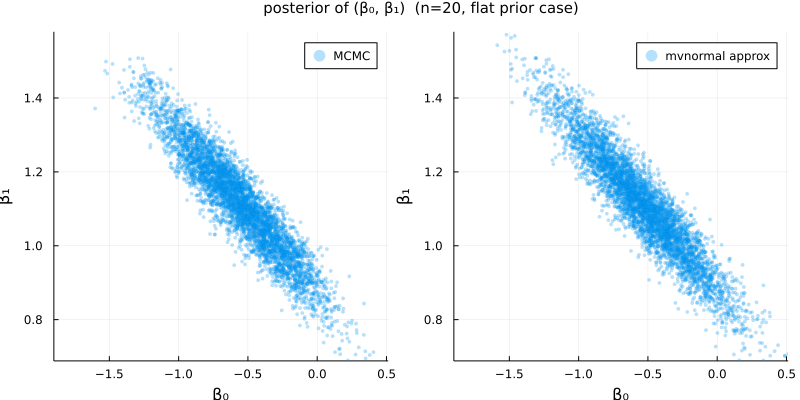

In [16]:
B0, B1 = vec(chn[:β₀]), vec(chn[:β₁])
xlim, ylim = quantile.(Ref(B0), (0.0001, 0.9999)), quantile.(Ref(B1), (0.001, 0.999))
mvnormal_approx = mvnormal_approx_posterior_poissonreg(x, y)
m = 5000
MV = rand(mvnormal_approx, m)

P1 = scatter(B0[1:m], B1[1:m]; label="MCMC", ms=2, msw=0, alpha=0.3)
plot!(; xguide="β₀", yguide="β₁", xlim, ylim)
P2 = scatter(MV[1,:], MV[2,:]; label="mvnormal approx", ms=2, msw=0, alpha=0.3)
plot!(; xguide="β₀", yguide="β₁", xlim, ylim)
plot(P1, P2; size=(800, 400), plot_title="posterior of (β₀, β₁)  (n=$n, flat prior case)")

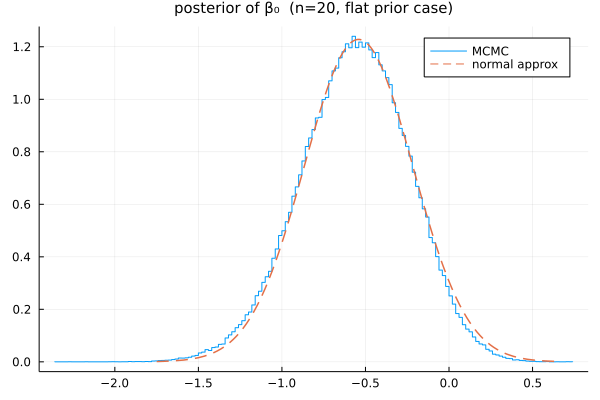

In [17]:
β̂, Σ̂ = params(mvnormal_approx)
normal_approx0 = Normal(β̂[1], √Σ̂[1,1])
stephist(B0; norm=true, label="MCMC")
plot!(normal_approx0; label="normal approx", ls=:dash, lw=1.5)
title!("posterior of β₀  (n=$n, flat prior case)")

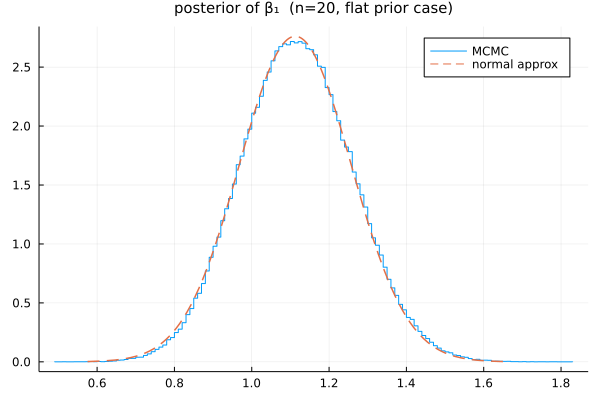

In [18]:
β̂, Σ̂ = params(mvnormal_approx)
normal_approx1 = Normal(β̂[2], √Σ̂[2,2])
stephist(B1; norm=true, label="MCMC")
plot!(normal_approx1; label="normal approx", ls=:dash, lw=1.5)
title!("posterior of β₁  (n=$n, flat prior case)")

## 正規事前分布の場合

In [19]:
@model function poissonreg_normalprior(x, y)
    β₀ ~ Normal(0, 2)
    β₁ ~ Normal(0, 2)
    for i in eachindex(x, y)
        y[i] ~ Poisson(exp(β₀ + β₁*x[i]))
    end
end

poissonreg_normalprior (generic function with 2 methods)

In [20]:
chn_np = sample(poissonreg_normalprior(x, y), NUTS(), MCMCThreads(), 10^5, 3);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191


In [21]:
chn_np

Chains MCMC chain (100000×14×3 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 3
Samples per chain = 100000
Wall duration     = 11.27 seconds
Compute duration  = 33.4 seconds
parameters        = β₀, β₁
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ess_per_sec 
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64       Float64 

          β₀   -0.5401    0.3208     0.0006    0.0012   67917.2276    1.0001     2033.5717
          β₁    1.1069    0.1428     0.0003    0.0005   68159.1346    1.0001     2040.8149

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          β₀   -1.1942   -0.7510   -0.53

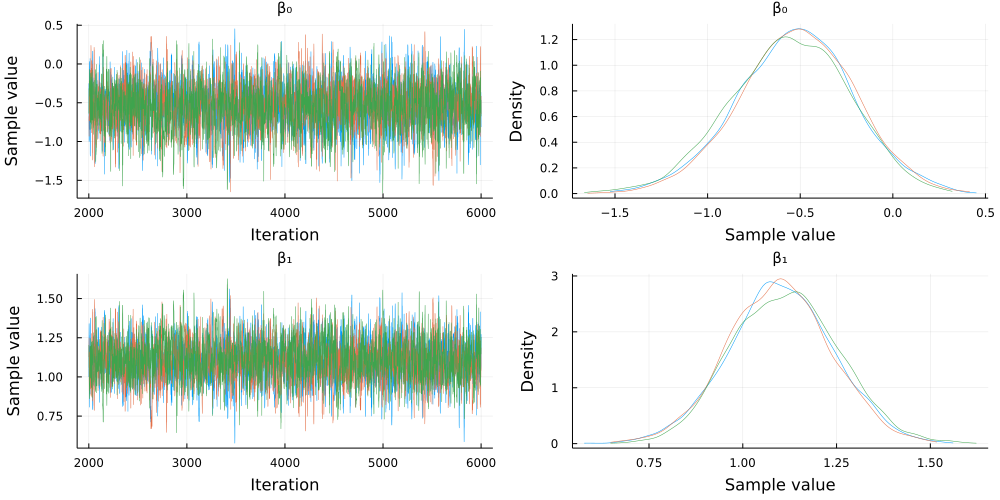

In [22]:
plot(chn_np[1001:5000]; lw=0.5, leftmargin=4Plots.mm, bottommargin=4Plots.mm)

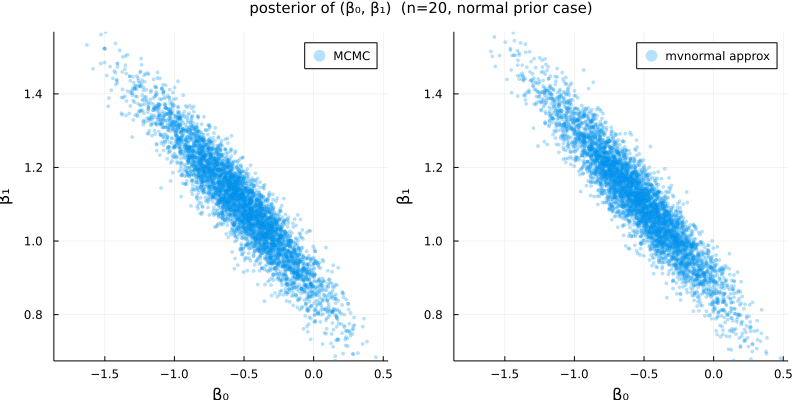

In [23]:
B0, B1 = vec(chn_np[:β₀]), vec(chn_np[:β₁])
xlim, ylim = quantile.(Ref(B0), (0.0001, 0.9999)), quantile.(Ref(B1), (0.001, 0.999))
mvnormal_approx = mvnormal_approx_posterior_poissonreg(x, y)
m = 5000
MV = rand(mvnormal_approx, m)

P1 = scatter(B0[1:m], B1[1:m]; label="MCMC", ms=2, msw=0, alpha=0.3)
plot!(; xguide="β₀", yguide="β₁", xlim, ylim)
P2 = scatter(MV[1,:], MV[2,:]; label="mvnormal approx", ms=2, msw=0, alpha=0.3)
plot!(; xguide="β₀", yguide="β₁", xlim, ylim)
plot(P1, P2; size=(800, 400), plot_title="posterior of (β₀, β₁)  (n=$n, normal prior case)")

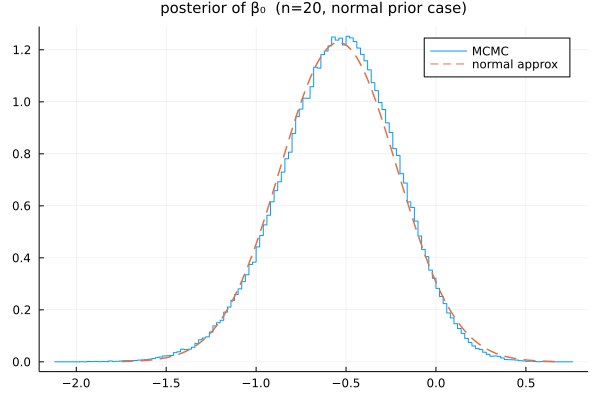

In [24]:
β̂, Σ̂ = params(mvnormal_approx)
normal_approx0 = Normal(β̂[1], √Σ̂[1,1])
stephist(B0; norm=true, label="MCMC")
plot!(normal_approx0; label="normal approx", ls=:dash, lw=1.5)
title!("posterior of β₀  (n=$n, normal prior case)")

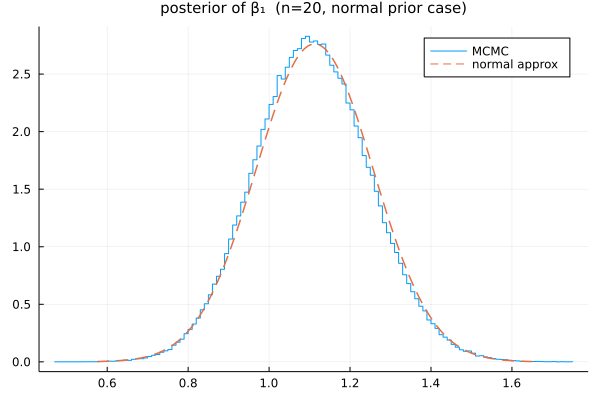

In [25]:
β̂, Σ̂ = params(mvnormal_approx)
normal_approx1 = Normal(β̂[2], √Σ̂[2,2])
stephist(B1; norm=true, label="MCMC")
plot!(normal_approx1; label="normal approx", ls=:dash, lw=1.5)
title!("posterior of β₁  (n=$n, normal prior case)")